# 2. Data Balance with Oversampling
---

In this notebook, we will look at the hashtags labels for each image, and fix the imbalance.

## Import Libraries (the following cells are copied from notebook 1)

In [10]:
import pandas as pd
import numpy as np
from scipy.linalg import null_space
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import sys
sys.path.append("../src")

## Create the Target Matrix
Form ```tag_list.txt``` and ```data_list.txt``` in HARRISON dataset, we create a target matrix as a DataFrame.

In [11]:
DATA_LIST = "../HARRISON/data_list.txt"
TAG_LIST = "../HARRISON/1113124810_tag_list.txt"

# Read files
filename = pd.read_csv(DATA_LIST, names=["filename"], header=None)
hashtag = pd.read_csv(TAG_LIST, names=["labels"], header=None)

# Convert filenames from "instagram_dataset/xxx/yyy.jpg" to "xxx_yyy.jpg"
filename["filename"] = filename["filename"].apply(lambda x: "_".join(x.split("/")[1:]))

# Concatenate filname and labels
target = pd.concat([filename, hashtag], axis=1)
target.head(5)

,filename,labels
0,sea_image_50.jpg,sea instapic instagram trip travel air beach b...
1,sea_image_1284.jpg,sea air beach boat earth fish ice island lake ...
2,sea_image_1122.jpg,sea love air beach boat earth fish ice island ...
3,sea_image_1679.jpg,beach sea trip island japan air beach boat ear...
4,sea_image_1736.jpg,sun sand sea sky friend beach thailand trip ad...


In [12]:
# Use vectorizer to generate a one-hot encoding
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(target["labels"])
columns = vectorizer.get_feature_names()
X_df = pd.DataFrame(X.toarray(), columns=columns)

# Combine hashtag encodings with file names
target = pd.concat([target, X_df], axis=1)
target = shuffle(target, random_state=42)

num_images = target.shape[0]
num_hashtags = X_df.shape[1]

## Visualize the data imbalance

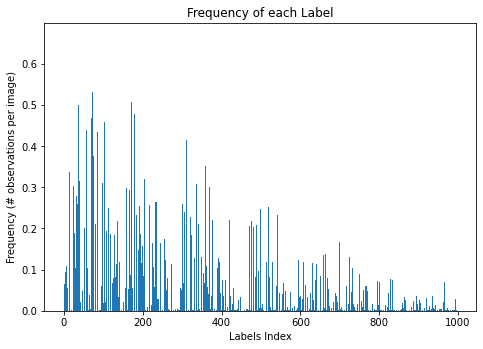

Variance in Frequency: 0.011785518548597274


In [13]:
def display_probability_bar_graph(label_series):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    row_names = np.arange(0,label_series.shape[0])#label_prob_df.index
    ax.bar(row_names,label_series)
    ax.set_title('Frequency of each Label')
    ax.set_ylabel('Frequency (# observations per image)')
    ax.set_xlabel('Labels Index')
    plt.show()
    print("Variance in Frequency:",label_series.var())
display_probability_bar_graph(X_df.sum(axis=0) / X_df.shape[0])

## Balance the data
Idea: We need to duplicate rows (images), so that all labels have the same frequency. If possible, we'd like to minimize the number of images duplicated. (Maybe also make small changes (crop or rotate) on the duplications)

#### Implementation 1: 
Solve the equation X(v)=0 ! (Find the kernel of X)

In [14]:
a = X_df.to_numpy()
row_multiples = null_space(a)

MemoryError: Unable to allocate 24.5 GiB for an array with shape (57383, 57383) and data type float64

Note the memory allocation issue! We will have to try something else.

#### Implementation 2:
We greedily choose a row with the least-represented labels to duplicate. Every iteration we duplicate the least-represented k rows.

In [6]:
#metrics for row duplication (more iterations and lower k yields better performance but slower)
num_iterations = 500 
k = 100 #number of images to duplicate per iteration

In [7]:
#dataframe appended to X_df in order to balance it
duplication_list_df = pd.DataFrame()

#frequency of each label in dataset
label_freq_df = X_df.sum(axis=0)

#find images to duplicate in each iteration
for i in range(num_iterations):
    
    #find probability of each label
    label_prob_df = label_freq_df / (X_df.shape[0] + i*k)
    label_prob_df_mean = label_prob_df.mean() 
    
    #evaluate score of each instance (score is an arbitary metric: number of labels that are underrepresented)
    labels_above_mean_mask = 1 * (label_prob_df < label_prob_df_mean)
    instance_scores = X_df.dot(labels_above_mean_mask) + (0 == X_df).dot(labels_above_mean_mask == 0)
    
    #find images to duplicate
    duplicated_rows_indices = np.argpartition(-1 * instance_scores, k)[:k]
    
    #mask the rows to duplicate (only keep tags less frequent than mean)
    duplicated_rows = X_df.iloc[duplicated_rows_indices] * labels_above_mean_mask
    
    #update the label frequency using k least likely instances
    label_freq_df += duplicated_rows.sum(axis=0)
    
    #update the duplication dict   
    duplication_list_df = duplication_list_df.append(duplicated_rows)
    
    #check variance and print
    new_var = label_prob_df.var()
    print("Completed",i+1,"iterations of",k,"duplications. Previous Variance:",label_prob_df.var())
        
print('Done!')
    

Completed 1 iterations of 100 duplications. Previous Variance: 0.011785518548597274
Completed 2 iterations of 100 duplications. Previous Variance: 0.01173749109598467
Completed 3 iterations of 100 duplications. Previous Variance: 0.011689743527214152
Completed 4 iterations of 100 duplications. Previous Variance: 0.011642402480485788
Completed 5 iterations of 100 duplications. Previous Variance: 0.01159543314323562
Completed 6 iterations of 100 duplications. Previous Variance: 0.011548593953994336
Completed 7 iterations of 100 duplications. Previous Variance: 0.01150216869390054
Completed 8 iterations of 100 duplications. Previous Variance: 0.011455895498945014
Completed 9 iterations of 100 duplications. Previous Variance: 0.011410151622620934
Completed 10 iterations of 100 duplications. Previous Variance: 0.011364603686764231
Completed 11 iterations of 100 duplications. Previous Variance: 0.011319301553450123
Completed 12 iterations of 100 duplications. Previous Variance: 0.01127426017

Completed 98 iterations of 100 duplications. Previous Variance: 0.008279886500118986
Completed 99 iterations of 100 duplications. Previous Variance: 0.008252719037982713
Completed 100 iterations of 100 duplications. Previous Variance: 0.008225859511911834
Completed 101 iterations of 100 duplications. Previous Variance: 0.008198932017062014
Completed 102 iterations of 100 duplications. Previous Variance: 0.008172260466033617
Completed 103 iterations of 100 duplications. Previous Variance: 0.0081455302856545
Completed 104 iterations of 100 duplications. Previous Variance: 0.008119097206501683
Completed 105 iterations of 100 duplications. Previous Variance: 0.008092628025439077
Completed 106 iterations of 100 duplications. Previous Variance: 0.008066391838467211
Completed 107 iterations of 100 duplications. Previous Variance: 0.008040328400619379
Completed 108 iterations of 100 duplications. Previous Variance: 0.008014368557276792
Completed 109 iterations of 100 duplications. Previous Var

Completed 194 iterations of 100 duplications. Previous Variance: 0.006182972394059712
Completed 195 iterations of 100 duplications. Previous Variance: 0.006165393361371217
Completed 196 iterations of 100 duplications. Previous Variance: 0.006148150445825647
Completed 197 iterations of 100 duplications. Previous Variance: 0.006130868441874658
Completed 198 iterations of 100 duplications. Previous Variance: 0.006113549512642605
Completed 199 iterations of 100 duplications. Previous Variance: 0.006096530715658133
Completed 200 iterations of 100 duplications. Previous Variance: 0.006079332576917451
Completed 201 iterations of 100 duplications. Previous Variance: 0.006062265944046381
Completed 202 iterations of 100 duplications. Previous Variance: 0.006045312218761152
Completed 203 iterations of 100 duplications. Previous Variance: 0.006028347238025247
Completed 204 iterations of 100 duplications. Previous Variance: 0.006011550723554869
Completed 205 iterations of 100 duplications. Previous

Completed 290 iterations of 100 duplications. Previous Variance: 0.004795160803561047
Completed 291 iterations of 100 duplications. Previous Variance: 0.004783299547357035
Completed 292 iterations of 100 duplications. Previous Variance: 0.0047714582998222834
Completed 293 iterations of 100 duplications. Previous Variance: 0.004759657925629323
Completed 294 iterations of 100 duplications. Previous Variance: 0.004747830343547742
Completed 295 iterations of 100 duplications. Previous Variance: 0.004736087558655752
Completed 296 iterations of 100 duplications. Previous Variance: 0.0047244645028031804
Completed 297 iterations of 100 duplications. Previous Variance: 0.004712823520059352
Completed 298 iterations of 100 duplications. Previous Variance: 0.004701316820551157
Completed 299 iterations of 100 duplications. Previous Variance: 0.004689831726150732
Completed 300 iterations of 100 duplications. Previous Variance: 0.004678474659643472
Completed 301 iterations of 100 duplications. Previo

Completed 386 iterations of 100 duplications. Previous Variance: 0.0038269848690149115
Completed 387 iterations of 100 duplications. Previous Variance: 0.0038184704607216804
Completed 388 iterations of 100 duplications. Previous Variance: 0.003810047564667668
Completed 389 iterations of 100 duplications. Previous Variance: 0.0038016231442381345
Completed 390 iterations of 100 duplications. Previous Variance: 0.0037932087835594332
Completed 391 iterations of 100 duplications. Previous Variance: 0.003784851813682816
Completed 392 iterations of 100 duplications. Previous Variance: 0.003776442328637795
Completed 393 iterations of 100 duplications. Previous Variance: 0.0037681722181966706
Completed 394 iterations of 100 duplications. Previous Variance: 0.003759858015181511
Completed 395 iterations of 100 duplications. Previous Variance: 0.0037515529875049207
Completed 396 iterations of 100 duplications. Previous Variance: 0.0037432345284666778
Completed 397 iterations of 100 duplications. P

Completed 481 iterations of 100 duplications. Previous Variance: 0.0031273025743378652
Completed 482 iterations of 100 duplications. Previous Variance: 0.003120928734887162
Completed 483 iterations of 100 duplications. Previous Variance: 0.0031146393111686024
Completed 484 iterations of 100 duplications. Previous Variance: 0.003108335603342916
Completed 485 iterations of 100 duplications. Previous Variance: 0.0031020360633363794
Completed 486 iterations of 100 duplications. Previous Variance: 0.0030958277221008095
Completed 487 iterations of 100 duplications. Previous Variance: 0.003089597603861473
Completed 488 iterations of 100 duplications. Previous Variance: 0.0030833430601064924
Completed 489 iterations of 100 duplications. Previous Variance: 0.0030771181956324397
Completed 490 iterations of 100 duplications. Previous Variance: 0.0030710094391089536
Completed 491 iterations of 100 duplications. Previous Variance: 0.0030648143519801723
Completed 492 iterations of 100 duplications. 

In [8]:
#duplicate the lines specified in duplication_list
balanced_X_df = X_df.append(duplication_list_df)

## Visualized Balanced Data

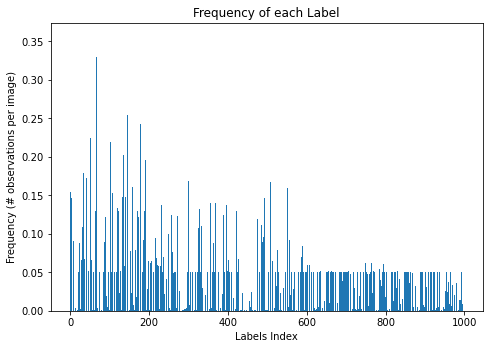

Variance in Frequency: 0.003004261546474527


In [9]:
display_probability_bar_graph(balanced_X_df.sum(axis=0) / balanced_X_df.shape[0])